In [41]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Conv3D
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import initializers
from sklearn.pipeline import make_pipeline, Pipeline
import matplotlib.pyplot as plt
import scipy.io



## 1. Load Dataset  and  Data Pre-processing

In [3]:
data = h5py.File('SVHN_single_grey1.h5', 'r')
print(len(data))
xtrain = data["X_train"][:]
ytrain = data["y_train"][:]

#Test set
xtest = data["X_test"][:]
ytest = data["y_test"][:]

# Validation Set
xval = data["X_val"][:]
yval = data["y_val"][:]



6
42000
42000
18000
18000


In [77]:
print("Shape of xtrain : {0}", xtrain.shape)
print("Shape of ytrain : {0}", ytrain.shape)
print("Shape of xtest : {0}", xtest.shape)
print("Shape of ytest : {0}", ytest.shape)
print("Shape of xval : {0}", xval.shape)
print("Shape of yval : {0}", yval.shape)

Shape of xtrain : {0} (42000, 32, 32)
Shape of ytrain : {0} (42000,)
Shape of xtest : {0} (18000, 32, 32)
Shape of ytest : {0} (18000,)
Shape of xval : {0} (60000, 32, 32)
Shape of yval : {0} (60000,)


## 2. Data Pipeline

### One-hot encode the class vector
- convert class vectors (integers) to binary class matrix
- convert y_train and y_test
- number of classes: 10
- we are doing this to use categorical_crossentropy as loss

In [78]:
# reshaping X data: (n, 32, 32) => (n, 1024)
x_train = xtrain.reshape(42000, 1024)
x_test = xtest.reshape(18000, 1024)
x_val = xval.reshape(60000, 1024)
# converting y data into categorical (one-hot encoding)
y_train = to_categorical(ytrain)
y_test = to_categorical(ytest)
y_val = to_categorical(yval)

In [79]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape)

(42000, 1024) (18000, 1024) (42000, 10) (18000, 10) (60000, 1024) (60000, 10)


In [453]:
# Normalize features from 0-255 to 0-1
print(x_train.max().round())
print(x_train.min())
def Normalize(x , xtest, xval):
    X_train_normalize = x / 255.0
    x_test_normalize = xtest / 255.0
    x_val_normalize = xval/ 255.0
    return X_train_normalize.round(), x_test_normalize.round(), x_val_normalize.round()


X_train_normalize, x_test_normalize, x_val_normalize = Normalize(x_train, x_test, x_val)
print(X_train_normalize.max().round())
print(x_test_normalize.max().round())

255.0
0.0
1.0
1.0


###  Observation
1. Normalizing the dat so that value is with in range of 0 and 1

## 3. Data fetching and understand the train/val/test splits. (15 points) 

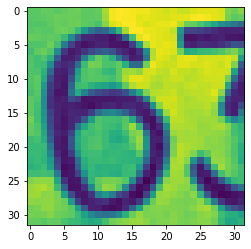

Label:  6


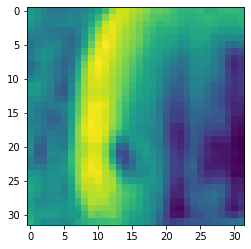

Label:  1


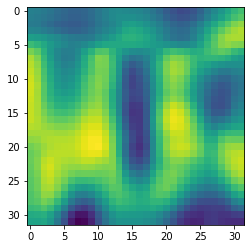

Label:  0


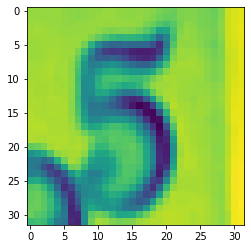

Label:  5


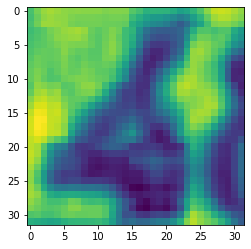

Label:  4


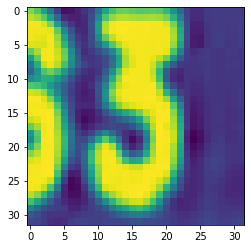

Label:  3


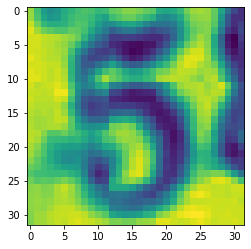

Label:  5


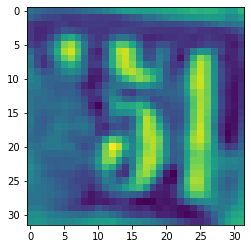

Label:  5


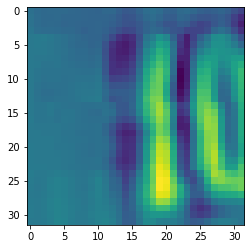

Label:  1


In [272]:
#1. We have already splitted the data in Training test and validation
# seeing few samples of the output data
index = [1,10,35,47,89,900,380, 1004,2567]
for i in index :
    plt.imshow(xtrain[i]) 
    plt.show()
    print('Label: ', ytrain[i])


label for each of the below image: 2
label for each of the below image: 6
label for each of the below image: 7
label for each of the below image: 4
label for each of the below image: 4
label for each of the below image: 0
label for each of the below image: 3
label for each of the below image: 0
label for each of the below image: 7
label for each of the below image: 3


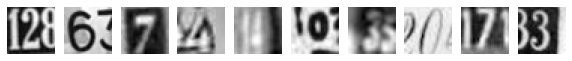

In [392]:
import numpy as np

# visualizing the first 10 images in the dataset and their labels
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i].reshape(32, 32), cmap="gray")
    plt.axis('off')
    print('label for each of the below image: %s' % (np.argmax(y_train[0:10][i])))
plt.show()

In [497]:
from tensorflow.keras.utils import to_categorical

print("Value before encoding:", y_train[0])

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("Shape of y_train:", y_train.shape)
print("One hot encoded value of y_train:", y_train[0])

Value before encoding: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Shape of y_train: (42000, 10, 10)
One hot encoded value of y_train: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Observation
1. Dataset consists of 42000 test images of size 32 * 32.
2. output consists of street images with numbers being displayed from 0-9
3. Also The data has been split in 3 so that if desired accuracy is not achieved in training then we can try on validation set as well
4. x_train and y_test contain greyscale RGB codes (from 0 to 255) while y_train and y_test contains labels from 0 to 9 which represents which number they actually are.

### 4. Implement and apply a deep neural network classifier including (feedforward neural network, RELU, activations) (25 points)  
### 5. Implement batch normalization for training the neural network(10 points)



###  Approach-1 
##### 1. Model will have one input node  1, hidden node and 1 output node
##### 2. Will test the model performance with and without batchnormalization, weight updation ,droupout.
##### 3. If the model accuracy is not coming as expected then will increse the hidden layers
##### 4. Also will heck the accuracy on normalized and normal  training values
##### 5. If the accuracy on training set will not be measurable will make use of Validation set for training the data

In [500]:

# 1. The Sequential model is a linear stack of layers.
# 2. The model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model
# (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape.
# 3. .fit() trains the model for a fixed number of epochs (iterations on a dataset)
# 4. An epoch is an iteration over the entire x and y data provided
# 5. batch_size is the number of samples per gradient update
# 6. Will vary the hyperparameter to check for better accuracy


In [420]:
def train_and_test_loop(iterations, lr, Lambda, x_train, verb=True):

    #hyperparameters
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
        
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(1024,), activation='relu'))
    model.add(Dense(hidden_nodes, activation='relu'))
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    sgd = optimizers.SGD(lr=learning_rate)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])   
    model.fit(x_train, y_train, epochs=iterations, batch_size=1000, verbose= 1)
    score = model.evaluate(x_train, y_train, verbose=0)
    
    # Fit the model   
    return score, model


In [421]:
lr = 0.00001
Lambda = 0
x_train = x_train.reshape(42000, 1024)
x_test = x_test.reshape(18000, 1024)
score, model = train_and_test_loop(100, lr, Lambda, x_train)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/100
42/42 [==============================] - 1s 25ms/step - loss: 66.7021 - accuracy: 0.1047
Epoch 2/100
42/42 [==============================] - 1s 25ms/step - loss: 29.9180 - accuracy: 0.1099: 0s - loss: 29.9180 - accuracy: 0.109
Epoch 3/100
42/42 [==============================] - 1s 26ms/step - loss: 26.4629 - accuracy: 0.1094
Epoch 4/100
42/42 [==============================] - 1s 26ms/step - loss: 24.1685 - accuracy: 0.1084
Epoch 5/100
42/42 [==============================] - 1s 26ms/step - loss: 22.3945 - accuracy: 0.1092
Epoch 6/100
42/42 [==============================] - 1s 26ms/step - loss: 20.9521 - accuracy: 0.1097
Epoch 7/100
42/42 [==============================] - 1s 25ms/step - loss: 19.7756 - accuracy: 0.1116
Epoch 8/100
42/42 [==============================] - 1s 25ms/step - loss: 18.8016 - accuracy: 0.1116
Epoch 9/100
42/42 [==============================] - 1s 25ms/step - loss: 17.9734 - accuracy: 0.1132
Epoch 10/100
42/42 [==============================] -

42/42 [==============================] - 1s 24ms/step - loss: 6.3368 - accuracy: 0.2238 0s - l
Epoch 81/100
42/42 [==============================] - 1s 24ms/step - loss: 6.3465 - accuracy: 0.2229 0s - loss: 6.3790 - accuracy: 
Epoch 82/100
42/42 [==============================] - 1s 24ms/step - loss: 6.2915 - accuracy: 0.2252
Epoch 83/100
42/42 [==============================] - 1s 24ms/step - loss: 6.2991 - accuracy: 0.2259
Epoch 84/100
42/42 [==============================] - 1s 23ms/step - loss: 6.2373 - accuracy: 0.2273
Epoch 85/100
42/42 [==============================] - 1s 24ms/step - loss: 6.1923 - accuracy: 0.2292
Epoch 86/100
42/42 [==============================] - 1s 23ms/step - loss: 6.1351 - accuracy: 0.2285
Epoch 87/100
42/42 [==============================] - 1s 25ms/step - loss: 6.1567 - accuracy: 0.2304
Epoch 88/100
42/42 [==============================] - 1s 24ms/step - loss: 6.1503 - accuracy: 0.2301
Epoch 89/100
42/42 [==============================] - 1s 24ms/step

In [422]:
# using normalized value
lr = 0.00001
Lambda = 0
X_train_normalize, x_test_normalize, x_val_normalize = Normalize(x_train, x_test, x_val)
score, model = train_and_test_loop(100, lr, Lambda,X_train_normalize)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test_normalize, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/100
42/42 [==============================] - 1s 24ms/step - loss: 2.4354 - accuracy: 0.1035
Epoch 2/100
42/42 [==============================] - 1s 24ms/step - loss: 2.4342 - accuracy: 0.1035
Epoch 3/100
42/42 [==============================] - 1s 24ms/step - loss: 2.4330 - accuracy: 0.1035
Epoch 4/100
42/42 [==============================] - 1s 24ms/step - loss: 2.4318 - accuracy: 0.1035
Epoch 5/100
42/42 [==============================] - 1s 24ms/step - loss: 2.4306 - accuracy: 0.1033
Epoch 6/100
42/42 [==============================] - 1s 24ms/step - loss: 2.4295 - accuracy: 0.1033
Epoch 7/100
42/42 [==============================] - 1s 25ms/step - loss: 2.4284 - accuracy: 0.1036
Epoch 8/100
42/42 [==============================] - 1s 24ms/step - loss: 2.4272 - accuracy: 0.1038
Epoch 9/100
42/42 [==============================] - 1s 24ms/step - loss: 2.4262 - accuracy: 0.1040
Epoch 10/100
42/42 [==============================] - 1s 24ms/step - loss: 2.4251 - accuracy: 0.1040

Epoch 82/100
42/42 [==============================] - 1s 25ms/step - loss: 2.3760 - accuracy: 0.1069
Epoch 83/100
42/42 [==============================] - 1s 25ms/step - loss: 2.3756 - accuracy: 0.1070
Epoch 84/100
42/42 [==============================] - 1s 25ms/step - loss: 2.3752 - accuracy: 0.1071
Epoch 85/100
42/42 [==============================] - 1s 25ms/step - loss: 2.3748 - accuracy: 0.1070
Epoch 86/100
42/42 [==============================] - 1s 25ms/step - loss: 2.3743 - accuracy: 0.1069
Epoch 87/100
42/42 [==============================] - ETA: 0s - loss: 2.3738 - accuracy: 0.10 - 1s 25ms/step - loss: 2.3739 - accuracy: 0.1070
Epoch 88/100
42/42 [==============================] - 1s 25ms/step - loss: 2.3735 - accuracy: 0.1069
Epoch 89/100
42/42 [==============================] - 1s 25ms/step - loss: 2.3731 - accuracy: 0.1071
Epoch 90/100
42/42 [==============================] - 1s 26ms/step - loss: 2.3727 - accuracy: 0.1071
Epoch 91/100
42/42 [=============================

### Observation

1. Loss barely changing. Learning rate is probably too low.

###  Weight Updation on Approach 1

In [423]:
# Weight Updation
def train_and_test_loop_withWeightUpdation(iterations, lr, Lambda, x_train, verb=True):
     #hyperparameters
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
        
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(1024,), activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(hidden_nodes, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    sgd = optimizers.SGD(lr=learning_rate)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    model.fit(x_train, y_train, epochs=iterations, batch_size=1000, verbose= 1)
    score = model.evaluate(x_train, y_train, verbose=0)
    
    # Fit the model   
    return score, model

In [424]:
#using normalized values
lr = 0.00001
Lambda = 0
X_train_normalize, x_test_normalize, x_val_normalize = Normalize(x_train, x_test, x_val)
score, model = train_and_test_loop_withWeightUpdation(100, lr, Lambda,X_train_normalize)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test_normalize, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/100
42/42 [==============================] - 1s 24ms/step - loss: 2.5294 - accuracy: 0.0999
Epoch 2/100
42/42 [==============================] - 1s 25ms/step - loss: 2.5246 - accuracy: 0.0998
Epoch 3/100
42/42 [==============================] - 1s 25ms/step - loss: 2.5199 - accuracy: 0.0998
Epoch 4/100
42/42 [==============================] - 1s 24ms/step - loss: 2.5154 - accuracy: 0.0995
Epoch 5/100
42/42 [==============================] - 1s 25ms/step - loss: 2.5111 - accuracy: 0.0995
Epoch 6/100
42/42 [==============================] - 1s 24ms/step - loss: 2.5070 - accuracy: 0.0995
Epoch 7/100
42/42 [==============================] - 1s 24ms/step - loss: 2.5030 - accuracy: 0.0996
Epoch 8/100
42/42 [==============================] - 1s 24ms/step - loss: 2.4992 - accuracy: 0.0996
Epoch 9/100
42/42 [==============================] - 1s 24ms/step - loss: 2.4955 - accuracy: 0.0996
Epoch 10/100
42/42 [==============================] - 1s 24ms/step - loss: 2.4920 - accuracy: 0.0995

42/42 [==============================] - 1s 24ms/step - loss: 2.3957 - accuracy: 0.0977
Epoch 82/100
42/42 [==============================] - 1s 24ms/step - loss: 2.3953 - accuracy: 0.0978
Epoch 83/100
42/42 [==============================] - 1s 23ms/step - loss: 2.3949 - accuracy: 0.0978
Epoch 84/100
42/42 [==============================] - 1s 24ms/step - loss: 2.3944 - accuracy: 0.0978
Epoch 85/100
42/42 [==============================] - 1s 24ms/step - loss: 2.3940 - accuracy: 0.0980
Epoch 86/100
42/42 [==============================] - 1s 23ms/step - loss: 2.3936 - accuracy: 0.0979
Epoch 87/100
42/42 [==============================] - 1s 24ms/step - loss: 2.3932 - accuracy: 0.0980
Epoch 88/100
42/42 [==============================] - 1s 24ms/step - loss: 2.3929 - accuracy: 0.0979
Epoch 89/100
42/42 [==============================] - 1s 23ms/step - loss: 2.3925 - accuracy: 0.0978
Epoch 90/100
42/42 [==============================] - 1s 23ms/step - loss: 2.3921 - accuracy: 0.0979
Epo

In [425]:
lr = 0.00001
Lambda = 0
x_train = x_train.reshape(42000, 1024)
x_test = x_test.reshape(18000, 1024)
score, model = train_and_test_loop_withWeightUpdation(100, lr, Lambda,x_train)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/100
42/42 [==============================] - 1s 25ms/step - loss: 92.6300 - accuracy: 0.1013: 0s - loss: 117.0327 - accu
Epoch 2/100
42/42 [==============================] - 1s 24ms/step - loss: 38.9673 - accuracy: 0.1039
Epoch 3/100
42/42 [==============================] - 1s 24ms/step - loss: 34.1637 - accuracy: 0.1080
Epoch 4/100
42/42 [==============================] - 1s 24ms/step - loss: 30.9039 - accuracy: 0.1113: 0s - loss: 32.7309 - ac
Epoch 5/100
42/42 [==============================] - 1s 24ms/step - loss: 28.4558 - accuracy: 0.1152
Epoch 6/100
42/42 [==============================] - 1s 24ms/step - loss: 26.5250 - accuracy: 0.1198
Epoch 7/100
42/42 [==============================] - 1s 24ms/step - loss: 24.9825 - accuracy: 0.1230
Epoch 8/100
42/42 [==============================] - 1s 24ms/step - loss: 23.7238 - accuracy: 0.1265
Epoch 9/100
42/42 [==============================] - 1s 24ms/step - loss: 22.6911 - accuracy: 0.1286
Epoch 10/100
42/42 [==================

42/42 [==============================] - 1s 23ms/step - loss: 8.4753 - accuracy: 0.2594
Epoch 81/100
42/42 [==============================] - 1s 23ms/step - loss: 8.3599 - accuracy: 0.2594
Epoch 82/100
42/42 [==============================] - 1s 24ms/step - loss: 8.3086 - accuracy: 0.2615
Epoch 83/100
42/42 [==============================] - 1s 24ms/step - loss: 8.2910 - accuracy: 0.2605
Epoch 84/100
42/42 [==============================] - 1s 24ms/step - loss: 8.1010 - accuracy: 0.2663
Epoch 85/100
42/42 [==============================] - 1s 24ms/step - loss: 8.0351 - accuracy: 0.2665
Epoch 86/100
42/42 [==============================] - 1s 24ms/step - loss: 8.1630 - accuracy: 0.2660
Epoch 87/100
42/42 [==============================] - 1s 24ms/step - loss: 8.0571 - accuracy: 0.2675
Epoch 88/100
42/42 [==============================] - 1s 23ms/step - loss: 8.0392 - accuracy: 0.2676
Epoch 89/100
42/42 [==============================] - 1s 24ms/step - loss: 8.0096 - accuracy: 0.2670
Epo

## Observation

1. Weight initialization is not working on approach 1.
2. The accuracy is not even measurable. Also the accuracy is consistently reducing in caseof training data set
3. loss is superbly high when we use normalized value of x train 
4. Loss barely changing. Learning rate is probably too low. Lets change in next iteration







### BatchNormalization on Approach 1

In [426]:

def train_and_test_loop_withBatchNormalization(iterations, lr, Lambda, x_train, verb=True):

     #hyperparameters
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
        
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(1024,)))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))  
    model.add(Dense(hidden_nodes))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))  
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=iterations, batch_size=1000, verbose= 1)
    score = model.evaluate(x_train, y_train, verbose=0)
    
    # Fit the model   
    return score, model



In [427]:
lr = 0.00001
Lambda = .1
x_train = x_train.reshape(42000, 1024)
x_test = x_test.reshape(18000, 1024)
score, model = train_and_test_loop_withBatchNormalization(100, lr, Lambda, x_train)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/100
42/42 [==============================] - 1s 35ms/step - loss: 4.5169 - accuracy: 0.1016
Epoch 2/100
42/42 [==============================] - 1s 35ms/step - loss: 4.5037 - accuracy: 0.1024
Epoch 3/100
42/42 [==============================] - 1s 35ms/step - loss: 4.4895 - accuracy: 0.1025
Epoch 4/100
42/42 [==============================] - 1s 36ms/step - loss: 4.4766 - accuracy: 0.1039
Epoch 5/100
42/42 [==============================] - 1s 35ms/step - loss: 4.4642 - accuracy: 0.1040
Epoch 6/100
42/42 [==============================] - 1s 35ms/step - loss: 4.4527 - accuracy: 0.1043
Epoch 7/100
42/42 [==============================] - 1s 36ms/step - loss: 4.4400 - accuracy: 0.1053
Epoch 8/100
42/42 [==============================] - 1s 35ms/step - loss: 4.4290 - accuracy: 0.1059
Epoch 9/100
42/42 [==============================] - 1s 35ms/step - loss: 4.4174 - accuracy: 0.1060
Epoch 10/100
42/42 [==============================] - 1s 35ms/step - loss: 4.4066 - accuracy: 0.1075

42/42 [==============================] - 2s 36ms/step - loss: 3.9459 - accuracy: 0.1602
Epoch 82/100
42/42 [==============================] - 1s 36ms/step - loss: 3.9409 - accuracy: 0.1617
Epoch 83/100
42/42 [==============================] - 1s 34ms/step - loss: 3.9361 - accuracy: 0.1622
Epoch 84/100
42/42 [==============================] - 1s 34ms/step - loss: 3.9317 - accuracy: 0.1634
Epoch 85/100
42/42 [==============================] - 1s 34ms/step - loss: 3.9270 - accuracy: 0.1644
Epoch 86/100
42/42 [==============================] - 1s 34ms/step - loss: 3.9224 - accuracy: 0.1649
Epoch 87/100
42/42 [==============================] - 1s 34ms/step - loss: 3.9178 - accuracy: 0.1661
Epoch 88/100
42/42 [==============================] - 1s 34ms/step - loss: 3.9128 - accuracy: 0.1668
Epoch 89/100
42/42 [==============================] - 1s 35ms/step - loss: 3.9082 - accuracy: 0.1690
Epoch 90/100
42/42 [==============================] - 1s 34ms/step - loss: 3.9041 - accuracy: 0.1686
Epo

In [428]:
# changing value of learning rate to check the impact 
lr = 0.01
Lambda = .1
x_train = x_train.reshape(42000, 1024)
x_test = x_test.reshape(18000, 1024)
score, model = train_and_test_loop_withBatchNormalization(100, lr, Lambda,x_train)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/100
42/42 [==============================] - 1s 34ms/step - loss: 3.3241 - accuracy: 0.2771
Epoch 2/100
42/42 [==============================] - 1s 35ms/step - loss: 2.0381 - accuracy: 0.5332
Epoch 3/100
42/42 [==============================] - 1s 35ms/step - loss: 1.7612 - accuracy: 0.6065
Epoch 4/100
42/42 [==============================] - 1s 35ms/step - loss: 1.6219 - accuracy: 0.6490
Epoch 5/100
42/42 [==============================] - 1s 34ms/step - loss: 1.5207 - accuracy: 0.6764
Epoch 6/100
42/42 [==============================] - 1s 35ms/step - loss: 1.4412 - accuracy: 0.6940
Epoch 7/100
42/42 [==============================] - 1s 34ms/step - loss: 1.3734 - accuracy: 0.7119
Epoch 8/100
42/42 [==============================] - 1s 35ms/step - loss: 1.3186 - accuracy: 0.7242
Epoch 9/100
42/42 [==============================] - 1s 34ms/step - loss: 1.2680 - accuracy: 0.7366
Epoch 10/100
42/42 [==============================] - 1s 35ms/step - loss: 1.2200 - accuracy: 0.7507

42/42 [==============================] - 2s 38ms/step - loss: 0.5736 - accuracy: 0.9034
Epoch 83/100
42/42 [==============================] - 2s 39ms/step - loss: 0.5736 - accuracy: 0.9037
Epoch 84/100
42/42 [==============================] - 2s 37ms/step - loss: 0.5635 - accuracy: 0.9086
Epoch 85/100
42/42 [==============================] - 2s 38ms/step - loss: 0.5622 - accuracy: 0.9070
Epoch 86/100
42/42 [==============================] - 2s 38ms/step - loss: 0.5628 - accuracy: 0.9065
Epoch 87/100
42/42 [==============================] - 1s 34ms/step - loss: 0.5575 - accuracy: 0.9083
Epoch 88/100
42/42 [==============================] - 2s 36ms/step - loss: 0.5556 - accuracy: 0.9079
Epoch 89/100
42/42 [==============================] - 2s 38ms/step - loss: 0.5569 - accuracy: 0.9075
Epoch 90/100
42/42 [==============================] - 1s 35ms/step - loss: 0.5503 - accuracy: 0.9112
Epoch 91/100
42/42 [==============================] - 2s 37ms/step - loss: 0.5512 - accuracy: 0.9098
Epo

In [429]:
# using normalized values along with updated learning rate to check the impact 
lr = 0.01
Lambda = .1
X_train_normalize, x_test_normalize, x_val_normalize = Normalize(x_train, x_test, x_val)
score, model = train_and_test_loop_withBatchNormalization(100, lr, Lambda, X_train_normalize)
print("Accuracy in training dataset: {0}", score[1])
result = model.evaluate(x_test_normalize, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/100
42/42 [==============================] - 2s 38ms/step - loss: 3.4245 - accuracy: 0.1733
Epoch 2/100
42/42 [==============================] - 2s 37ms/step - loss: 2.2832 - accuracy: 0.3044
Epoch 3/100
42/42 [==============================] - 2s 36ms/step - loss: 2.0974 - accuracy: 0.3451
Epoch 4/100
42/42 [==============================] - 2s 36ms/step - loss: 2.0218 - accuracy: 0.3736
Epoch 5/100
42/42 [==============================] - 2s 38ms/step - loss: 1.9667 - accuracy: 0.3938
Epoch 6/100
42/42 [==============================] - 1s 36ms/step - loss: 1.9232 - accuracy: 0.4128
Epoch 7/100
42/42 [==============================] - 2s 39ms/step - loss: 1.8848 - accuracy: 0.4269
Epoch 8/100
42/42 [==============================] - 2s 38ms/step - loss: 1.8522 - accuracy: 0.4373
Epoch 9/100
42/42 [==============================] - 2s 36ms/step - loss: 1.8233 - accuracy: 0.4488
Epoch 10/100
42/42 [==============================] - 2s 36ms/step - loss: 1.7956 - accuracy: 0.4552

42/42 [==============================] - 1s 34ms/step - loss: 1.1631 - accuracy: 0.6682
Epoch 83/100
42/42 [==============================] - 1s 35ms/step - loss: 1.1579 - accuracy: 0.6698
Epoch 84/100
42/42 [==============================] - 1s 35ms/step - loss: 1.1528 - accuracy: 0.6709
Epoch 85/100
42/42 [==============================] - 1s 34ms/step - loss: 1.1475 - accuracy: 0.6723
Epoch 86/100
42/42 [==============================] - 1s 34ms/step - loss: 1.1472 - accuracy: 0.6723
Epoch 87/100
42/42 [==============================] - 1s 34ms/step - loss: 1.1405 - accuracy: 0.6773
Epoch 88/100
42/42 [==============================] - 1s 35ms/step - loss: 1.1353 - accuracy: 0.6759
Epoch 89/100
42/42 [==============================] - 1s 34ms/step - loss: 1.1321 - accuracy: 0.6774
Epoch 90/100
42/42 [==============================] - 1s 34ms/step - loss: 1.1277 - accuracy: 0.6806
Epoch 91/100
42/42 [==============================] - 1s 34ms/step - loss: 1.1199 - accuracy: 0.6831
Epo

### Observation

1.  Batch normalization with updated value of learning rate improved accuracy to 91 percent in training but it seems the model is becoming overfit. We will try to reduce the overfitting by adding dropout layers
2. Normalized values are reducing the model accuracy and increases the loss
3. Changing(Reducing Learning rate) has improved the accuracy to a considerable percentage

### Applying Dropouts on approach 1

In [430]:
# adding 1 droupout
def train_and_test_loop_withOneDropouts(iterations,lr, Lambda, x_train, verb=True):

     #hyperparameters
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
      
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(1024,)))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))  
    
    model.add(Dense(hidden_nodes))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    sgd = optimizers.SGD(lr=learning_rate)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer= sgd , metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=iterations, batch_size=1000, verbose= 1)
    score = model.evaluate(x_train, y_train, verbose=0)
    
    # Fit the model   
    return score, model

In [431]:
# changing value of learning rate to check the impact 
lr = 0.01
Lambda = .1
x_train = x_train.reshape(42000, 1024)
x_test = x_test.reshape(18000, 1024)
score, model = train_and_test_loop_withOneDropouts(200, lr, Lambda, x_train)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/200
42/42 [==============================] - 2s 38ms/step - loss: 4.2649 - accuracy: 0.1364
Epoch 2/200
42/42 [==============================] - 2s 38ms/step - loss: 3.7286 - accuracy: 0.1982
Epoch 3/200
42/42 [==============================] - 2s 38ms/step - loss: 3.3766 - accuracy: 0.2536
Epoch 4/200
42/42 [==============================] - 2s 37ms/step - loss: 3.0939 - accuracy: 0.3031
Epoch 5/200
42/42 [==============================] - 2s 38ms/step - loss: 2.8674 - accuracy: 0.3482
Epoch 6/200
42/42 [==============================] - 2s 37ms/step - loss: 2.6798 - accuracy: 0.3893
Epoch 7/200
42/42 [==============================] - 2s 38ms/step - loss: 2.5295 - accuracy: 0.4233
Epoch 8/200
42/42 [==============================] - 2s 38ms/step - loss: 2.4023 - accuracy: 0.4524
Epoch 9/200
42/42 [==============================] - 2s 38ms/step - loss: 2.2975 - accuracy: 0.4806
Epoch 10/200
42/42 [==============================] - 2s 38ms/step - loss: 2.2090 - accuracy: 0.5025

42/42 [==============================] - 2s 37ms/step - loss: 1.2231 - accuracy: 0.7545
Epoch 83/200
42/42 [==============================] - 2s 37ms/step - loss: 1.2168 - accuracy: 0.7569
Epoch 84/200
42/42 [==============================] - 2s 39ms/step - loss: 1.2129 - accuracy: 0.7560 1s -
Epoch 85/200
42/42 [==============================] - 2s 37ms/step - loss: 1.2097 - accuracy: 0.7565
Epoch 86/200
42/42 [==============================] - 2s 37ms/step - loss: 1.2037 - accuracy: 0.7586
Epoch 87/200
42/42 [==============================] - 2s 38ms/step - loss: 1.2002 - accuracy: 0.7600
Epoch 88/200
42/42 [==============================] - 2s 37ms/step - loss: 1.1953 - accuracy: 0.7593
Epoch 89/200
42/42 [==============================] - 2s 37ms/step - loss: 1.1907 - accuracy: 0.7614
Epoch 90/200
42/42 [==============================] - 2s 37ms/step - loss: 1.1885 - accuracy: 0.7619
Epoch 91/200
42/42 [==============================] - 2s 38ms/step - loss: 1.1822 - accuracy: 0.764

42/42 [==============================] - 2s 37ms/step - loss: 0.9664 - accuracy: 0.8210
Epoch 163/200
42/42 [==============================] - 2s 37ms/step - loss: 0.9654 - accuracy: 0.8202
Epoch 164/200
42/42 [==============================] - 2s 37ms/step - loss: 0.9626 - accuracy: 0.8217
Epoch 165/200
42/42 [==============================] - 2s 38ms/step - loss: 0.9611 - accuracy: 0.8219
Epoch 166/200
42/42 [==============================] - 2s 37ms/step - loss: 0.9598 - accuracy: 0.8224
Epoch 167/200
42/42 [==============================] - 2s 37ms/step - loss: 0.9566 - accuracy: 0.8228
Epoch 168/200
42/42 [==============================] - 2s 37ms/step - loss: 0.9537 - accuracy: 0.8243
Epoch 169/200
42/42 [==============================] - 2s 37ms/step - loss: 0.9534 - accuracy: 0.8225
Epoch 170/200
42/42 [==============================] - 2s 37ms/step - loss: 0.9520 - accuracy: 0.8235
Epoch 171/200
42/42 [==============================] - 2s 37ms/step - loss: 0.9489 - accuracy: 0

In [433]:
# changing value of learning rate to check the impact 
lr = 0.01
Lambda = .0015
x_train = x_train.reshape(42000, 1024)
x_test = x_test.reshape(18000, 1024)
score, model = train_and_test_loop_withOneDropouts(120, lr, Lambda, x_train)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/120
42/42 [==============================] - 2s 38ms/step - loss: 2.5693 - accuracy: 0.1264
Epoch 2/120
42/42 [==============================] - 2s 37ms/step - loss: 2.2876 - accuracy: 0.1930
Epoch 3/120
42/42 [==============================] - 2s 39ms/step - loss: 2.1441 - accuracy: 0.2576
Epoch 4/120
42/42 [==============================] - 2s 41ms/step - loss: 2.0188 - accuracy: 0.3097
Epoch 5/120
42/42 [==============================] - 2s 39ms/step - loss: 1.9118 - accuracy: 0.3635
Epoch 6/120
42/42 [==============================] - 2s 39ms/step - loss: 1.8125 - accuracy: 0.4045
Epoch 7/120
42/42 [==============================] - 2s 41ms/step - loss: 1.7319 - accuracy: 0.4377
Epoch 8/120
42/42 [==============================] - 2s 37ms/step - loss: 1.6590 - accuracy: 0.4705
Epoch 9/120
42/42 [==============================] - 2s 37ms/step - loss: 1.5901 - accuracy: 0.4998
Epoch 10/120
42/42 [==============================] - 2s 40ms/step - loss: 1.5286 - accuracy: 0.5257

42/42 [==============================] - 2s 43ms/step - loss: 0.6471 - accuracy: 0.8197
Epoch 83/120
42/42 [==============================] - 2s 38ms/step - loss: 0.6519 - accuracy: 0.8152
Epoch 84/120
42/42 [==============================] - 2s 38ms/step - loss: 0.6389 - accuracy: 0.8213
Epoch 85/120
42/42 [==============================] - 2s 42ms/step - loss: 0.6325 - accuracy: 0.8227
Epoch 86/120
42/42 [==============================] - 2s 39ms/step - loss: 0.6300 - accuracy: 0.8248
Epoch 87/120
42/42 [==============================] - 2s 38ms/step - loss: 0.6342 - accuracy: 0.8232
Epoch 88/120
42/42 [==============================] - 2s 38ms/step - loss: 0.6303 - accuracy: 0.8248
Epoch 89/120
42/42 [==============================] - 2s 38ms/step - loss: 0.6326 - accuracy: 0.8222
Epoch 90/120
42/42 [==============================] - 2s 38ms/step - loss: 0.6219 - accuracy: 0.8260
Epoch 91/120
42/42 [==============================] - 2s 38ms/step - loss: 0.6179 - accuracy: 0.8284
Epo

In [434]:
### adding 2 dropouts to avoid overfitting 

def train_and_test_loop_withDropouts(iterations,lr, Lambda, x_train, verb=True):

     #hyperparameters
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
      
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(1024,)))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))  
    model.add(Dropout(0.2))
    
    model.add(Dense(hidden_nodes))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    sgd = optimizers.SGD(lr=learning_rate)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer= sgd , metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=iterations, batch_size=1000, verbose= 1)
    score = model.evaluate(x_train, y_train, verbose=0)
    
    # Fit the model   
    return score, model

In [435]:

lr = 0.01
Lambda = .0015
x_train = x_train.reshape(42000, 1024)
x_test = x_test.reshape(18000, 1024)
score, model = train_and_test_loop_withDropouts(150, lr, Lambda, x_train)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/150
42/42 [==============================] - 2s 41ms/step - loss: 2.6397 - accuracy: 0.1129
Epoch 2/150
42/42 [==============================] - 2s 41ms/step - loss: 2.4265 - accuracy: 0.1444
Epoch 3/150
42/42 [==============================] - 2s 41ms/step - loss: 2.3271 - accuracy: 0.1772
Epoch 4/150
42/42 [==============================] - 2s 42ms/step - loss: 2.2340 - accuracy: 0.2144
Epoch 5/150
42/42 [==============================] - 2s 41ms/step - loss: 2.1539 - accuracy: 0.2460
Epoch 6/150
42/42 [==============================] - 2s 42ms/step - loss: 2.0785 - accuracy: 0.2814
Epoch 7/150
42/42 [==============================] - 2s 43ms/step - loss: 2.0064 - accuracy: 0.3129
Epoch 8/150
42/42 [==============================] - 2s 43ms/step - loss: 1.9353 - accuracy: 0.3421
Epoch 9/150
42/42 [==============================] - 2s 43ms/step - loss: 1.8711 - accuracy: 0.3701
Epoch 10/150
42/42 [==============================] - 2s 43ms/step - loss: 1.8115 - accuracy: 0.3926

42/42 [==============================] - 2s 41ms/step - loss: 0.8718 - accuracy: 0.7448
Epoch 81/150
42/42 [==============================] - 2s 41ms/step - loss: 0.8666 - accuracy: 0.7455
Epoch 82/150
42/42 [==============================] - 2s 40ms/step - loss: 0.8615 - accuracy: 0.7490
Epoch 83/150
42/42 [==============================] - 2s 43ms/step - loss: 0.8641 - accuracy: 0.7459
Epoch 84/150
42/42 [==============================] - 2s 43ms/step - loss: 0.8584 - accuracy: 0.7509
Epoch 85/150
42/42 [==============================] - 2s 42ms/step - loss: 0.8520 - accuracy: 0.7534
Epoch 86/150
42/42 [==============================] - 2s 40ms/step - loss: 0.8507 - accuracy: 0.7521
Epoch 87/150
42/42 [==============================] - 2s 41ms/step - loss: 0.8488 - accuracy: 0.7525
Epoch 88/150
42/42 [==============================] - 2s 41ms/step - loss: 0.8419 - accuracy: 0.7551
Epoch 89/150
42/42 [==============================] - 2s 40ms/step - loss: 0.8407 - accuracy: 0.7535
Epo

## We got so far the best accuracy

In [436]:
lr = 0.01
Lambda = .0015
X_train_normalize, x_test_normalize, x_val_normalize = Normalize(x_train, x_test, x_val)
score, model = train_and_test_loop_withDropouts(150, lr, Lambda, X_train_normalize)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test_normalize, y_test)
print("Accuracy in test dataset : {0}", testscore[1])


Epoch 1/150
42/42 [==============================] - 2s 41ms/step - loss: 2.6468 - accuracy: 0.1061
Epoch 2/150
42/42 [==============================] - 2s 41ms/step - loss: 2.5334 - accuracy: 0.1188
Epoch 3/150
42/42 [==============================] - 2s 41ms/step - loss: 2.4628 - accuracy: 0.1313
Epoch 4/150
42/42 [==============================] - 2s 41ms/step - loss: 2.4119 - accuracy: 0.1461
Epoch 5/150
42/42 [==============================] - 2s 41ms/step - loss: 2.3679 - accuracy: 0.1598
Epoch 6/150
42/42 [==============================] - 2s 41ms/step - loss: 2.3246 - accuracy: 0.1739
Epoch 7/150
42/42 [==============================] - 2s 41ms/step - loss: 2.2918 - accuracy: 0.1840
Epoch 8/150
42/42 [==============================] - 2s 41ms/step - loss: 2.2585 - accuracy: 0.1963
Epoch 9/150
42/42 [==============================] - 2s 48ms/step - loss: 2.2296 - accuracy: 0.2060
Epoch 10/150
42/42 [==============================] - 2s 42ms/step - loss: 2.1968 - accuracy: 0.2176

42/42 [==============================] - 2s 41ms/step - loss: 1.5905 - accuracy: 0.4441
Epoch 82/150
42/42 [==============================] - 2s 40ms/step - loss: 1.5857 - accuracy: 0.4474
Epoch 83/150
42/42 [==============================] - 2s 40ms/step - loss: 1.5878 - accuracy: 0.4454
Epoch 84/150
42/42 [==============================] - 2s 40ms/step - loss: 1.5828 - accuracy: 0.4467
Epoch 85/150
42/42 [==============================] - 2s 41ms/step - loss: 1.5830 - accuracy: 0.4472
Epoch 86/150
42/42 [==============================] - 2s 40ms/step - loss: 1.5800 - accuracy: 0.4478
Epoch 87/150
42/42 [==============================] - 2s 40ms/step - loss: 1.5767 - accuracy: 0.4496
Epoch 88/150
42/42 [==============================] - 2s 40ms/step - loss: 1.5745 - accuracy: 0.4510
Epoch 89/150
42/42 [==============================] - 2s 40ms/step - loss: 1.5719 - accuracy: 0.4495
Epoch 90/150
42/42 [==============================] - 2s 41ms/step - loss: 1.5651 - accuracy: 0.4552
Epo

In [437]:
lr = 0.067754567
Lambda = .0015
x_train = x_train.reshape(42000, 1024)
x_test = x_test.reshape(18000, 1024)
score, model = train_and_test_loop_withDropouts(180, lr, Lambda, x_train)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/180
42/42 [==============================] - 2s 40ms/step - loss: 2.3245 - accuracy: 0.1993
Epoch 2/180
42/42 [==============================] - 2s 40ms/step - loss: 1.8396 - accuracy: 0.3863
Epoch 3/180
42/42 [==============================] - 2s 40ms/step - loss: 1.5590 - accuracy: 0.5018
Epoch 4/180
42/42 [==============================] - 2s 40ms/step - loss: 1.3977 - accuracy: 0.5635
Epoch 5/180
42/42 [==============================] - 2s 42ms/step - loss: 1.2897 - accuracy: 0.6015
Epoch 6/180
42/42 [==============================] - 2s 40ms/step - loss: 1.2153 - accuracy: 0.6266
Epoch 7/180
42/42 [==============================] - 2s 40ms/step - loss: 1.1621 - accuracy: 0.6464
Epoch 8/180
42/42 [==============================] - 2s 40ms/step - loss: 1.1088 - accuracy: 0.6644
Epoch 9/180
42/42 [==============================] - 2s 41ms/step - loss: 1.0898 - accuracy: 0.6687
Epoch 10/180
42/42 [==============================] - 2s 40ms/step - loss: 1.0412 - accuracy: 0.6862

42/42 [==============================] - 2s 40ms/step - loss: 0.5456 - accuracy: 0.8441
Epoch 82/180
42/42 [==============================] - 2s 40ms/step - loss: 0.5283 - accuracy: 0.8511
Epoch 83/180
42/42 [==============================] - 2s 41ms/step - loss: 0.5667 - accuracy: 0.8387
Epoch 84/180
42/42 [==============================] - 2s 40ms/step - loss: 0.5275 - accuracy: 0.8502
Epoch 85/180
42/42 [==============================] - 2s 41ms/step - loss: 0.5305 - accuracy: 0.8503
Epoch 86/180
42/42 [==============================] - 2s 41ms/step - loss: 0.5553 - accuracy: 0.8410
Epoch 87/180
42/42 [==============================] - 2s 39ms/step - loss: 0.5269 - accuracy: 0.8501
Epoch 88/180
42/42 [==============================] - 2s 39ms/step - loss: 0.5392 - accuracy: 0.8467
Epoch 89/180
42/42 [==============================] - 2s 40ms/step - loss: 0.5507 - accuracy: 0.8431
Epoch 90/180
42/42 [==============================] - 2s 40ms/step - loss: 0.5265 - accuracy: 0.8500
Epo

42/42 [==============================] - 2s 41ms/step - loss: 0.4366 - accuracy: 0.8759
Epoch 162/180
42/42 [==============================] - 2s 41ms/step - loss: 0.4330 - accuracy: 0.8773
Epoch 163/180
42/42 [==============================] - 2s 39ms/step - loss: 0.4149 - accuracy: 0.8841
Epoch 164/180
42/42 [==============================] - 2s 40ms/step - loss: 0.4170 - accuracy: 0.8823
Epoch 165/180
42/42 [==============================] - 2s 40ms/step - loss: 0.4508 - accuracy: 0.8732
Epoch 166/180
42/42 [==============================] - 2s 40ms/step - loss: 0.4301 - accuracy: 0.8778
Epoch 167/180
42/42 [==============================] - 2s 39ms/step - loss: 0.4187 - accuracy: 0.8832
Epoch 168/180
42/42 [==============================] - 2s 40ms/step - loss: 0.4254 - accuracy: 0.8802
Epoch 169/180
42/42 [==============================] - 2s 39ms/step - loss: 0.4179 - accuracy: 0.8825
Epoch 170/180
42/42 [==============================] - 2s 40ms/step - loss: 0.4264 - accuracy: 0

### Observation
1. Dropout layer has totally reduced the overfitting but also reduced the accuracy. 
2. Will Add more hidden layers to increase the model accuracy

In [438]:
# Adding more layers and using adam optimizer

def train_and_test_loop_withmoreLayersandAdamOptimizer(iterations, Lambda, verb=True):

     #hyperparameters
    hidden_nodes = 256
    output_nodes = 10
      
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(1024,)))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.5))
    
    model.add(Dense(hidden_nodes))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.5))
    
    model.add(Dense(hidden_nodes))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.5))
    
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=iterations, batch_size=1000, verbose= 1)
    score = model.evaluate(x_train, y_train, verbose=0)
    # Fit the model   
    return score, model

In [439]:
Lambda = 0.015
x_train = x_train.reshape(42000, 1024)
x_test = x_test.reshape(18000, 1024)
score, model = train_and_test_loop_withmoreLayersandAdamOptimizer(120, Lambda)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/120
42/42 [==============================] - 2s 57ms/step - loss: 2.8899 - accuracy: 0.1199
Epoch 2/120
42/42 [==============================] - 3s 64ms/step - loss: 2.4110 - accuracy: 0.1867
Epoch 3/120
42/42 [==============================] - 2s 59ms/step - loss: 2.0148 - accuracy: 0.3096
Epoch 4/120
42/42 [==============================] - 3s 60ms/step - loss: 1.7479 - accuracy: 0.4182
Epoch 5/120
42/42 [==============================] - 2s 59ms/step - loss: 1.5752 - accuracy: 0.4895
Epoch 6/120
42/42 [==============================] - 2s 58ms/step - loss: 1.4566 - accuracy: 0.5403 0s - los - ETA: 0s - loss: 1.4590 - accuracy: 
Epoch 7/120
42/42 [==============================] - 2s 59ms/step - loss: 1.3595 - accuracy: 0.5757
Epoch 8/120
42/42 [==============================] - 2s 57ms/step - loss: 1.2787 - accuracy: 0.6072
Epoch 9/120
42/42 [==============================] - 2s 59ms/step - loss: 1.2280 - accuracy: 0.6253
Epoch 10/120
42/42 [==============================] -

Epoch 80/120
42/42 [==============================] - 2s 58ms/step - loss: 0.6180 - accuracy: 0.8159
Epoch 81/120
42/42 [==============================] - 2s 57ms/step - loss: 0.6244 - accuracy: 0.8145
Epoch 82/120
42/42 [==============================] - 2s 57ms/step - loss: 0.6236 - accuracy: 0.8157
Epoch 83/120
42/42 [==============================] - 2s 56ms/step - loss: 0.6115 - accuracy: 0.8180
Epoch 84/120
42/42 [==============================] - 2s 57ms/step - loss: 0.6115 - accuracy: 0.8183
Epoch 85/120
42/42 [==============================] - 2s 58ms/step - loss: 0.6079 - accuracy: 0.8196 1s - los
Epoch 86/120
42/42 [==============================] - 2s 59ms/step - loss: 0.6074 - accuracy: 0.8206
Epoch 87/120
42/42 [==============================] - 2s 58ms/step - loss: 0.6084 - accuracy: 0.8195
Epoch 88/120
42/42 [==============================] - 2s 57ms/step - loss: 0.6057 - accuracy: 0.8195
Epoch 89/120
42/42 [==============================] - 2s 57ms/step - loss: 0.6101 

In [440]:
# Adding more layers

def train_and_test_loop_withmoreLayersandAdamOptimizer1(iterations, Lambda, verb=True):

     #hyperparameters
    hidden_nodes = 300
    output_nodes = 10
      
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(1024,)))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.3))
    
    model.add(Dense(hidden_nodes))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.3))
    
    model.add(Dense(hidden_nodes))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.3))
    
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=iterations, batch_size=1000, verbose= 1)
    score = model.evaluate(x_train, y_train, verbose=0)
    # Fit the model   
    return score, model

In [442]:
Lambda = 0.0015
x_train = x_train.reshape(42000, 1024)
x_test = x_test.reshape(18000, 1024)
score, model = train_and_test_loop_withmoreLayersandAdamOptimizer1(100, Lambda)
print("Accuracy in training dataset: {0}", score[1])
testscore = model.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/100
42/42 [==============================] - 3s 76ms/step - loss: 2.2854 - accuracy: 0.2275
Epoch 2/100
42/42 [==============================] - 3s 78ms/step - loss: 1.5178 - accuracy: 0.4910
Epoch 3/100
42/42 [==============================] - 3s 75ms/step - loss: 1.1995 - accuracy: 0.6140
Epoch 4/100
42/42 [==============================] - 3s 76ms/step - loss: 1.0592 - accuracy: 0.6674
Epoch 5/100
42/42 [==============================] - 3s 75ms/step - loss: 0.9797 - accuracy: 0.6976
Epoch 6/100
42/42 [==============================] - 3s 75ms/step - loss: 0.9143 - accuracy: 0.7204
Epoch 7/100
42/42 [==============================] - 3s 73ms/step - loss: 0.8570 - accuracy: 0.7373
Epoch 8/100
42/42 [==============================] - 3s 74ms/step - loss: 0.8218 - accuracy: 0.7468
Epoch 9/100
42/42 [==============================] - 3s 73ms/step - loss: 0.7827 - accuracy: 0.7608
Epoch 10/100
42/42 [==============================] - 3s 74ms/step - loss: 0.7567 - accuracy: 0.7680

42/42 [==============================] - 3s 76ms/step - loss: 0.3485 - accuracy: 0.8930
Epoch 82/100
42/42 [==============================] - 3s 76ms/step - loss: 0.3544 - accuracy: 0.8919
Epoch 83/100
42/42 [==============================] - 3s 77ms/step - loss: 0.3432 - accuracy: 0.8945
Epoch 84/100
42/42 [==============================] - 3s 78ms/step - loss: 0.3508 - accuracy: 0.8912
Epoch 85/100
42/42 [==============================] - 3s 75ms/step - loss: 0.3413 - accuracy: 0.8947
Epoch 86/100
42/42 [==============================] - 3s 75ms/step - loss: 0.3382 - accuracy: 0.8965
Epoch 87/100
42/42 [==============================] - 3s 76ms/step - loss: 0.3434 - accuracy: 0.8939
Epoch 88/100
42/42 [==============================] - 3s 76ms/step - loss: 0.3366 - accuracy: 0.8964
Epoch 89/100
42/42 [==============================] - 3s 76ms/step - loss: 0.3347 - accuracy: 0.8970
Epoch 90/100
42/42 [==============================] - 3s 76ms/step - loss: 0.3415 - accuracy: 0.8937
Epo

### Observations

1. As layers increases computational time increases and the model start becoming overfit but the accuracy also increases

### Trying to see the accuracy on the best combination of learning rate and lambda in validation dataset

In [457]:
# this was so far the best model that has given best accuracy
def train_and_test_loopFinalwithValidationData(iterations, lr, Lambda, verb=True):

     #hyperparameters
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
      
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(1024,)))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))  
    model.add(Dropout(0.2))
    
    model.add(Dense(hidden_nodes))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    sgd = optimizers.SGD(lr=learning_rate)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer= sgd , metrics=['accuracy'])
    model.fit(x_val, y_val, epochs=iterations, batch_size=1000, verbose= 1)
    score = model.evaluate(x_val, y_val, verbose=0)
    
    # Fit the model   
    return score, model

In [461]:
lr = 0.01
Lambda = .0015
x_val = x_val.reshape(60000, 1024)
x_test = x_test.reshape(18000, 1024)
score, model = train_and_test_loopFinalwithValidationData(200, lr, Lambda)
print("Accuracy in validation dataset: {0}", score[1])
testscore = model.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/200
42/42 [==============================] - 2s 46ms/step - loss: 2.6126 - accuracy: 0.1166
Epoch 2/200
42/42 [==============================] - 2s 45ms/step - loss: 2.4152 - accuracy: 0.1539
Epoch 3/200
42/42 [==============================] - 2s 44ms/step - loss: 2.3201 - accuracy: 0.1873
Epoch 4/200
42/42 [==============================] - 2s 45ms/step - loss: 2.2222 - accuracy: 0.2233
Epoch 5/200
42/42 [==============================] - 2s 51ms/step - loss: 2.1480 - accuracy: 0.2573
Epoch 6/200
42/42 [==============================] - 2s 44ms/step - loss: 2.0696 - accuracy: 0.2877
Epoch 7/200
42/42 [==============================] - 2s 45ms/step - loss: 1.9957 - accuracy: 0.3209 0s - loss: 1.9991 - accuracy
Epoch 8/200
42/42 [==============================] - 2s 49ms/step - loss: 1.9334 - accuracy: 0.3469
Epoch 9/200
42/42 [==============================] - 2s 44ms/step - loss: 1.8680 - accuracy: 0.3739
Epoch 10/200
42/42 [==============================] - 2s 44ms/step - lo

42/42 [==============================] - 2s 45ms/step - loss: 0.8673 - accuracy: 0.7493
Epoch 81/200
42/42 [==============================] - 2s 46ms/step - loss: 0.8668 - accuracy: 0.7479
Epoch 82/200
42/42 [==============================] - 2s 46ms/step - loss: 0.8619 - accuracy: 0.7496
Epoch 83/200
42/42 [==============================] - 2s 46ms/step - loss: 0.8607 - accuracy: 0.7508
Epoch 84/200
42/42 [==============================] - 2s 46ms/step - loss: 0.8489 - accuracy: 0.7526
Epoch 85/200
42/42 [==============================] - 2s 47ms/step - loss: 0.8503 - accuracy: 0.7540
Epoch 86/200
42/42 [==============================] - 2s 46ms/step - loss: 0.8458 - accuracy: 0.7551
Epoch 87/200
42/42 [==============================] - 2s 45ms/step - loss: 0.8459 - accuracy: 0.7547
Epoch 88/200
42/42 [==============================] - 2s 46ms/step - loss: 0.8333 - accuracy: 0.7588
Epoch 89/200
42/42 [==============================] - 2s 51ms/step - loss: 0.8363 - accuracy: 0.7584
Epo

42/42 [==============================] - 2s 46ms/step - loss: 0.6753 - accuracy: 0.8071
Epoch 161/200
42/42 [==============================] - 2s 46ms/step - loss: 0.6762 - accuracy: 0.8078
Epoch 162/200
42/42 [==============================] - 2s 45ms/step - loss: 0.6716 - accuracy: 0.8085
Epoch 163/200
42/42 [==============================] - 2s 45ms/step - loss: 0.6717 - accuracy: 0.8081 0s - loss: 0.670
Epoch 164/200
42/42 [==============================] - 2s 47ms/step - loss: 0.6690 - accuracy: 0.8099
Epoch 165/200
42/42 [==============================] - 2s 47ms/step - loss: 0.6677 - accuracy: 0.8068
Epoch 166/200
42/42 [==============================] - 2s 47ms/step - loss: 0.6658 - accuracy: 0.8088
Epoch 167/200
42/42 [==============================] - 2s 46ms/step - loss: 0.6682 - accuracy: 0.8096
Epoch 168/200
42/42 [==============================] - 2s 47ms/step - loss: 0.6643 - accuracy: 0.8085
Epoch 169/200
42/42 [==============================] - 2s 46ms/step - loss: 0.6

## Observations
1. The accuracy results are almost the same in validation and training set. But in validation it is slightly better

###  So far we have hit and trial the value of learning rate and lambda.  Now since we have finalized out model, lets try for different range of value for learning rate and lambda, for getting better accuracy results

In [463]:
def train_and_test_loopBestAccuracy(iterations, lr, Lambda, verb=True):

     #hyperparameters
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
      
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(1024,)))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))  
    model.add(Dropout(0.2))
    
    model.add(Dense(hidden_nodes))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    sgd = optimizers.SGD(lr=learning_rate)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer= sgd , metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=iterations, batch_size=1000, verbose= 1)
    score = model.evaluate(x_train, y_train, verbose=0)
    
    # Fit the model   
    return score, model

In [451]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-4, 4))
    Lambda = math.pow(10, np.random.uniform(-4, 2))
    best_acc, model = train_and_test_loopBestAccuracy(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Epoch 1/100
42/42 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0990
Epoch 2/100
42/42 [==============================] - 2s 46ms/step - loss: nan - accuracy: 0.0997
Epoch 3/100
42/42 [==============================] - 2s 49ms/step - loss: nan - accuracy: 0.0997
Epoch 4/100
42/42 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0997
Epoch 5/100
42/42 [==============================] - 2s 49ms/step - loss: nan - accuracy: 0.0997
Epoch 6/100
42/42 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0997
Epoch 7/100
42/42 [==============================] - 2s 47ms/step - loss: nan - accuracy: 0.0997
Epoch 8/100
42/42 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0997: 0s - loss: nan - accura
Epoch 9/100
42/42 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0997
Epoch 10/100
42/42 [==============================] - 2s 47ms/step - loss: nan - accuracy: 0.0997
Epoc

42/42 [==============================] - 2s 47ms/step - loss: nan - accuracy: 0.0997
Epoch 83/100
42/42 [==============================] - 2s 48ms/step - loss: nan - accuracy: 0.0997
Epoch 84/100
42/42 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0997
Epoch 85/100
42/42 [==============================] - 2s 46ms/step - loss: nan - accuracy: 0.0997
Epoch 86/100
42/42 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0997
Epoch 87/100
42/42 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0997
Epoch 88/100
42/42 [==============================] - 2s 46ms/step - loss: nan - accuracy: 0.0997
Epoch 89/100
42/42 [==============================] - 2s 46ms/step - loss: nan - accuracy: 0.0997
Epoch 90/100
42/42 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0997
Epoch 91/100
42/42 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0997
Epoch 92/100
42/42 [=============

42/42 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0997
Epoch 65/100
42/42 [==============================] - 2s 44ms/step - loss: nan - accuracy: 0.0997
Epoch 66/100
42/42 [==============================] - 2s 44ms/step - loss: nan - accuracy: 0.0997
Epoch 67/100
42/42 [==============================] - 2s 46ms/step - loss: nan - accuracy: 0.0997
Epoch 68/100
42/42 [==============================] - 2s 45ms/step - loss: nan - accuracy: 0.0997
Epoch 69/100
42/42 [==============================] - 2s 47ms/step - loss: nan - accuracy: 0.0997
Epoch 70/100
42/42 [==============================] - 2s 43ms/step - loss: nan - accuracy: 0.0997
Epoch 71/100
42/42 [==============================] - 2s 48ms/step - loss: nan - accuracy: 0.0997
Epoch 72/100
42/42 [==============================] - 2s 48ms/step - loss: nan - accuracy: 0.0997: 1s - loss: 
Epoch 73/100
42/42 [==============================] - 2s 48ms/step - loss: nan - accuracy: 0.0997
Epoch 74/100
42/42 [

42/42 [==============================] - 2s 46ms/step - loss: 2.1646 - accuracy: 0.3706
Epoch 45/100
42/42 [==============================] - 2s 49ms/step - loss: 2.1613 - accuracy: 0.3779
Epoch 46/100
42/42 [==============================] - 2s 47ms/step - loss: 2.1571 - accuracy: 0.3774
Epoch 47/100
42/42 [==============================] - 2s 44ms/step - loss: 2.1531 - accuracy: 0.3823
Epoch 48/100
42/42 [==============================] - 2s 43ms/step - loss: 2.1495 - accuracy: 0.3813
Epoch 49/100
42/42 [==============================] - 2s 46ms/step - loss: 2.1455 - accuracy: 0.3871
Epoch 50/100
42/42 [==============================] - 2s 43ms/step - loss: 2.1428 - accuracy: 0.3875
Epoch 51/100
42/42 [==============================] - 2s 42ms/step - loss: 2.1374 - accuracy: 0.3883
Epoch 52/100
42/42 [==============================] - 2s 43ms/step - loss: 2.1349 - accuracy: 0.3926
Epoch 53/100
42/42 [==============================] - 2s 42ms/step - loss: 2.1307 - accuracy: 0.3938
Epo

42/42 [==============================] - 2s 43ms/step - loss: 0.7816 - accuracy: 0.7793
Epoch 24/100
42/42 [==============================] - 2s 43ms/step - loss: 0.7840 - accuracy: 0.7777
Epoch 25/100
42/42 [==============================] - 2s 42ms/step - loss: 0.7668 - accuracy: 0.7846
Epoch 26/100
42/42 [==============================] - 2s 41ms/step - loss: 0.7556 - accuracy: 0.7860
Epoch 27/100
42/42 [==============================] - 2s 41ms/step - loss: 0.7492 - accuracy: 0.7895
Epoch 28/100
42/42 [==============================] - 2s 41ms/step - loss: 0.7430 - accuracy: 0.7890
Epoch 29/100
42/42 [==============================] - 2s 42ms/step - loss: 0.7301 - accuracy: 0.7952
Epoch 30/100
42/42 [==============================] - 2s 41ms/step - loss: 0.7350 - accuracy: 0.7926
Epoch 31/100
42/42 [==============================] - 2s 41ms/step - loss: 0.7181 - accuracy: 0.7968
Epoch 32/100
42/42 [==============================] - 2s 41ms/step - loss: 0.7175 - accuracy: 0.7986
Epo

42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.1001     
Epoch 2/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 3/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 4/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 5/100
42/42 [==============================] - 2s 41ms/step - loss: nan - accuracy: 0.0997
Epoch 6/100
42/42 [==============================] - 2s 43ms/step - loss: nan - accuracy: 0.0997
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 8/100
42/42 [==============================] - 2s 44ms/step - loss: nan - accuracy: 0.0997
Epoch 9/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 10/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 11/100
42/42 [================

42/42 [==============================] - 2s 44ms/step - loss: nan - accuracy: 0.0997
Epoch 83/100
42/42 [==============================] - 2s 47ms/step - loss: nan - accuracy: 0.0997
Epoch 84/100
42/42 [==============================] - 2s 41ms/step - loss: nan - accuracy: 0.0997
Epoch 85/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 86/100
42/42 [==============================] - 2s 41ms/step - loss: nan - accuracy: 0.0997
Epoch 87/100
42/42 [==============================] - 2s 41ms/step - loss: nan - accuracy: 0.0997
Epoch 88/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 89/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 90/100
42/42 [==============================] - 2s 43ms/step - loss: nan - accuracy: 0.0997
Epoch 91/100
42/42 [==============================] - 2s 43ms/step - loss: nan - accuracy: 0.0997
Epoch 92/100
42/42 [=============

42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 64/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 65/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 66/100
42/42 [==============================] - 2s 43ms/step - loss: nan - accuracy: 0.0997
Epoch 67/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 68/100
42/42 [==============================] - 2s 41ms/step - loss: nan - accuracy: 0.0997
Epoch 69/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 70/100
42/42 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0997
Epoch 71/100
42/42 [==============================] - 2s 41ms/step - loss: nan - accuracy: 0.0997
Epoch 72/100
42/42 [==============================] - 2s 46ms/step - loss: nan - accuracy: 0.0997
Epoch 73/100
42/42 [=============

42/42 [==============================] - 2s 47ms/step - loss: 2.2871 - accuracy: 0.2622 0s - loss: 2.2873 
Epoch 43/100
42/42 [==============================] - 2s 44ms/step - loss: 2.2859 - accuracy: 0.2635
Epoch 44/100
42/42 [==============================] - 2s 46ms/step - loss: 2.2852 - accuracy: 0.2641
Epoch 45/100
42/42 [==============================] - 2s 44ms/step - loss: 2.2840 - accuracy: 0.2648
Epoch 46/100
42/42 [==============================] - 2s 41ms/step - loss: 2.2837 - accuracy: 0.2637
Epoch 47/100
42/42 [==============================] - 2s 41ms/step - loss: 2.2828 - accuracy: 0.2690
Epoch 48/100
42/42 [==============================] - ETA: 0s - loss: 2.2822 - accuracy: 0.26 - 2s 42ms/step - loss: 2.2822 - accuracy: 0.2689
Epoch 49/100
42/42 [==============================] - 2s 42ms/step - loss: 2.2819 - accuracy: 0.2680
Epoch 50/100
42/42 [==============================] - 2s 42ms/step - loss: 2.2815 - accuracy: 0.2679
Epoch 51/100
42/42 [=======================

42/42 [==============================] - 2s 52ms/step - loss: 2.3866 - accuracy: 0.1527
Epoch 21/100
42/42 [==============================] - 2s 45ms/step - loss: 2.3831 - accuracy: 0.1546 0s - loss: 2.3826 - accura
Epoch 22/100
42/42 [==============================] - 2s 47ms/step - loss: 2.3683 - accuracy: 0.1581
Epoch 23/100
42/42 [==============================] - 2s 48ms/step - loss: 2.3606 - accuracy: 0.1621
Epoch 24/100
42/42 [==============================] - 2s 48ms/step - loss: 2.3487 - accuracy: 0.1679
Epoch 25/100
42/42 [==============================] - 2s 47ms/step - loss: 2.3460 - accuracy: 0.1671
Epoch 26/100
42/42 [==============================] - 2s 46ms/step - loss: 2.3317 - accuracy: 0.1707
Epoch 27/100
42/42 [==============================] - 2s 44ms/step - loss: 2.3212 - accuracy: 0.1726
Epoch 28/100
42/42 [==============================] - 2s 47ms/step - loss: 2.3190 - accuracy: 0.1744
Epoch 29/100
42/42 [==============================] - 2s 45ms/step - loss: 2.

42/42 [==============================] - 2s 50ms/step - loss: 1.8513 - accuracy: 0.3713
Try 8/100: Best_val_acc: [2.430185079574585, 0.09980952739715576], lr: 0.0008417164570475702, Lambda: 0.00011828373788279204

Epoch 1/100
42/42 [==============================] - 2s 45ms/step - loss: 2.8073 - accuracy: 0.0996
Epoch 2/100
42/42 [==============================] - 2s 46ms/step - loss: 2.7926 - accuracy: 0.0982
Epoch 3/100
42/42 [==============================] - 2s 47ms/step - loss: 2.7730 - accuracy: 0.1024
Epoch 4/100
42/42 [==============================] - 2s 46ms/step - loss: 2.7613 - accuracy: 0.1021
Epoch 5/100
42/42 [==============================] - 2s 47ms/step - loss: 2.7470 - accuracy: 0.1034
Epoch 6/100
42/42 [==============================] - 2s 48ms/step - loss: 2.7281 - accuracy: 0.1024
Epoch 7/100
42/42 [==============================] - 2s 46ms/step - loss: 2.7152 - accuracy: 0.1044
Epoch 8/100
42/42 [==============================] - 2s 46ms/step - loss: 2.7079 - acc

42/42 [==============================] - 2s 45ms/step - loss: 2.3880 - accuracy: 0.1525
Epoch 80/100
42/42 [==============================] - 2s 45ms/step - loss: 2.3822 - accuracy: 0.1537
Epoch 81/100
42/42 [==============================] - 2s 45ms/step - loss: 2.3779 - accuracy: 0.1564
Epoch 82/100
42/42 [==============================] - 2s 45ms/step - loss: 2.3772 - accuracy: 0.1548
Epoch 83/100
42/42 [==============================] - 2s 46ms/step - loss: 2.3768 - accuracy: 0.1570
Epoch 84/100
42/42 [==============================] - 2s 47ms/step - loss: 2.3736 - accuracy: 0.1588
Epoch 85/100
42/42 [==============================] - 2s 45ms/step - loss: 2.3727 - accuracy: 0.1606
Epoch 86/100
42/42 [==============================] - 2s 46ms/step - loss: 2.3748 - accuracy: 0.1596
Epoch 87/100
42/42 [==============================] - 2s 45ms/step - loss: 2.3664 - accuracy: 0.1595
Epoch 88/100
42/42 [==============================] - 2s 45ms/step - loss: 2.3669 - accuracy: 0.1605
Epo

### Observation
1. for lambda =  0.002870272892553188 and lr = 0.12353364166613577, the accuracy is very high, lets try and find out the accourcy in test set
2. for higher value of lambda loss is exploding

In [467]:
lr = 0.12353364166613577
Lambda = 0.002870272892553188
x_train = x_train.reshape(42000, 1024)
x_test = x_test.reshape(18000, 1024)
score, model = train_and_test_loopBestAccuracy(100, lr, Lambda)
testscore = model.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/100
42/42 [==============================] - 2s 43ms/step - loss: 2.1599 - accuracy: 0.2691 0s - loss: 2.295
Epoch 2/100
42/42 [==============================] - 2s 45ms/step - loss: 1.6188 - accuracy: 0.4862
Epoch 3/100
42/42 [==============================] - 2s 45ms/step - loss: 1.3887 - accuracy: 0.5719
Epoch 4/100
42/42 [==============================] - 2s 47ms/step - loss: 1.2582 - accuracy: 0.6215
Epoch 5/100
42/42 [==============================] - 2s 45ms/step - loss: 1.1945 - accuracy: 0.6435
Epoch 6/100
42/42 [==============================] - 2s 46ms/step - loss: 1.1194 - accuracy: 0.6672
Epoch 7/100
42/42 [==============================] - 2s 44ms/step - loss: 1.0970 - accuracy: 0.6760
Epoch 8/100
42/42 [==============================] - 2s 43ms/step - loss: 1.0448 - accuracy: 0.6913
Epoch 9/100
42/42 [==============================] - 2s 43ms/step - loss: 1.0256 - accuracy: 0.7002
Epoch 10/100
42/42 [==============================] - 2s 44ms/step - loss: 0.9828 -

42/42 [==============================] - 2s 42ms/step - loss: 0.5241 - accuracy: 0.8550
Epoch 81/100
42/42 [==============================] - 2s 42ms/step - loss: 0.5461 - accuracy: 0.8484
Epoch 82/100
42/42 [==============================] - 2s 42ms/step - loss: 0.5129 - accuracy: 0.8577
Epoch 83/100
42/42 [==============================] - 2s 41ms/step - loss: 0.5134 - accuracy: 0.8587
Epoch 84/100
42/42 [==============================] - 2s 45ms/step - loss: 0.5174 - accuracy: 0.8569
Epoch 85/100
42/42 [==============================] - 2s 46ms/step - loss: 0.5161 - accuracy: 0.8570
Epoch 86/100
42/42 [==============================] - 2s 44ms/step - loss: 0.5059 - accuracy: 0.8606
Epoch 87/100
42/42 [==============================] - 2s 45ms/step - loss: 0.5043 - accuracy: 0.8592
Epoch 88/100
42/42 [==============================] - 2s 44ms/step - loss: 0.4954 - accuracy: 0.8622
Epoch 89/100
42/42 [==============================] - 2s 45ms/step - loss: 0.5192 - accuracy: 0.8555
Epo

### observation

1. This model overfits in est set

# Final Model

In [471]:
def train_and_test_loopFinal(iterations, lr, Lambda, verb=True):

     #hyperparameters
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
      
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(1024,)))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))  
    model.add(Dropout(0.2))
    
    model.add(Dense(hidden_nodes))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    sgd = optimizers.SGD(lr=learning_rate)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer= sgd , metrics=['accuracy'])
    model.fit(x_val, y_val, epochs=iterations, batch_size=1000, verbose= 1)
    score = model.evaluate(x_val, y_val, verbose=0)
    
    # Fit the model   
    return score, model

In [472]:
lr = 0.01
Lambda = .0015
x_val = x_val.reshape(60000, 1024)
x_test = x_test.reshape(18000, 1024)
score, finalmodel = train_and_test_loopFinalwithValidationData(200, lr, Lambda)
print("Accuracy in validation dataset: {0}", score[1])
testscore = finalmodel.evaluate(x_test, y_test)
print("Accuracy in test dataset : {0}", testscore[1])

Epoch 1/200
42/42 [==============================] - 2s 45ms/step - loss: 2.6117 - accuracy: 0.1169
Epoch 2/200
42/42 [==============================] - 2s 44ms/step - loss: 2.4154 - accuracy: 0.1520
Epoch 3/200
42/42 [==============================] - 2s 43ms/step - loss: 2.3099 - accuracy: 0.1890 0s - loss: 2.3142 - accuracy: 
Epoch 4/200
42/42 [==============================] - 2s 44ms/step - loss: 2.2135 - accuracy: 0.2256
Epoch 5/200
42/42 [==============================] - 2s 48ms/step - loss: 2.1294 - accuracy: 0.2625
Epoch 6/200
42/42 [==============================] - 2s 46ms/step - loss: 2.0429 - accuracy: 0.2992
Epoch 7/200
42/42 [==============================] - 2s 47ms/step - loss: 1.9630 - accuracy: 0.3296
Epoch 8/200
42/42 [==============================] - 2s 45ms/step - loss: 1.8925 - accuracy: 0.3651
Epoch 9/200
42/42 [==============================] - 2s 44ms/step - loss: 1.8298 - accuracy: 0.3888 1s - los
Epoch 10/200
42/42 [==============================] - 2s 42m

Epoch 81/200
42/42 [==============================] - 2s 41ms/step - loss: 0.8695 - accuracy: 0.7447
Epoch 82/200
42/42 [==============================] - 2s 42ms/step - loss: 0.8655 - accuracy: 0.7442
Epoch 83/200
42/42 [==============================] - 2s 42ms/step - loss: 0.8625 - accuracy: 0.7479
Epoch 84/200
42/42 [==============================] - 2s 42ms/step - loss: 0.8579 - accuracy: 0.7497
Epoch 85/200
42/42 [==============================] - 2s 42ms/step - loss: 0.8557 - accuracy: 0.7496
Epoch 86/200
42/42 [==============================] - 2s 42ms/step - loss: 0.8494 - accuracy: 0.7531
Epoch 87/200
42/42 [==============================] - 2s 41ms/step - loss: 0.8479 - accuracy: 0.7540
Epoch 88/200
42/42 [==============================] - 2s 42ms/step - loss: 0.8407 - accuracy: 0.7543
Epoch 89/200
42/42 [==============================] - 2s 42ms/step - loss: 0.8423 - accuracy: 0.7555
Epoch 90/200
42/42 [==============================] - 2s 42ms/step - loss: 0.8356 - accurac

Epoch 161/200
42/42 [==============================] - 2s 43ms/step - loss: 0.6834 - accuracy: 0.8029
Epoch 162/200
42/42 [==============================] - 2s 41ms/step - loss: 0.6791 - accuracy: 0.8039
Epoch 163/200
42/42 [==============================] - 2s 42ms/step - loss: 0.6791 - accuracy: 0.8058
Epoch 164/200
42/42 [==============================] - 2s 43ms/step - loss: 0.6792 - accuracy: 0.8050
Epoch 165/200
42/42 [==============================] - 2s 43ms/step - loss: 0.6751 - accuracy: 0.8059
Epoch 166/200
42/42 [==============================] - 2s 41ms/step - loss: 0.6746 - accuracy: 0.8059
Epoch 167/200
42/42 [==============================] - 2s 42ms/step - loss: 0.6704 - accuracy: 0.8076
Epoch 168/200
42/42 [==============================] - 2s 42ms/step - loss: 0.6701 - accuracy: 0.8096
Epoch 169/200
42/42 [==============================] - 2s 42ms/step - loss: 0.6728 - accuracy: 0.8080
Epoch 170/200
42/42 [==============================] - 2s 41ms/step - loss: 0.6707

### 6. Print the classification accuracy metrics of final Model

In [476]:
finalmodel.summary()

Model: "sequential_301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1052 (Dense)           (None, 256)               262400    
_________________________________________________________________
batch_normalization_539 (Bat (None, 256)               1024      
_________________________________________________________________
activation_719 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_487 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_1053 (Dense)           (None, 256)               65792     
_________________________________________________________________
batch_normalization_540 (Bat (None, 256)               1024      
_________________________________________________________________
activation_720 (Activation)  (None, 256)            

In [492]:
from sklearn.metrics import classification_report, confusion_matrix
x_test = xtest.reshape(18000, 1024)
y_hat = finalmodel.predict_classes(x_test, batch_size=128, verbose=0)
print(y_hat)
pred = finalmodel.predict(x_test)
print(pred.round())


[2 7 2 ... 7 9 2]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]]


In [494]:
import numpy as np
y_test=np.argmax(y_test, axis=1)
y_test[1]

7

In [495]:
print(confusion_matrix(y_test, y_hat))

[[1602   25   20   12   32    3   27   28   22   43]
 [  21 1552   41   19   81    7   16   57   18   16]
 [  13   25 1582   18   32   17    7   60   18   31]
 [  18   46   74 1244   30  145   23   44   53   42]
 [  21   37   44   11 1609   15   22   15    7   31]
 [  15   19   25   64   26 1451   69   17   43   39]
 [  39   19   25   12   64   58 1530   11   56   18]
 [  15   59   69   17   16   10   13 1572   11   26]
 [  28   38   40   26   40   29  110   12 1421   68]
 [  61   27   42   35   32   39   14   27   43 1484]]


In [496]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1814
           1       0.84      0.85      0.84      1828
           2       0.81      0.88      0.84      1803
           3       0.85      0.72      0.78      1719
           4       0.82      0.89      0.85      1812
           5       0.82      0.82      0.82      1768
           6       0.84      0.84      0.84      1832
           7       0.85      0.87      0.86      1808
           8       0.84      0.78      0.81      1812
           9       0.83      0.82      0.82      1804

    accuracy                           0.84     18000
   macro avg       0.84      0.84      0.84     18000
weighted avg       0.84      0.84      0.84     18000



## Approach 2
Since this dataset is not giving accurate results using ANN lets try to see if we can increase the accuracy using CNN

In [126]:
x_train = x_train.reshape(42000, 32, 32, 1)
x_test = x_test.reshape(18000, 32, 32, 1)



(42000, 1024)
(18000, 1024)
(60000, 1024)


In [255]:


def train_and_test_Conv2DwithDropoutAndBatchNormalization(lr, Lambda, verb=True):

    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
        
    model = Sequential() 
    model.add(Conv2D(32, (2, 2), input_shape=(32, 32, 1))) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (2, 2))) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Dropout(0.2))
    
    model.add(Flatten()) 
    model.add(BatchNormalization())
    model.add(Dense(hidden_nodes))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10)) 
    model.add(Activation('softmax')) 
 
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fit the model
    
    return model

In [257]:
lr = 0.00001
Lambda = 0.1
x_train = x_train.reshape(42000, 32, 32, 1)
x_test = x_test.reshape(18000, 32, 32, 1)
model = train_and_test_Conv2DwithDropoutAndBatchNormalization(lr, Lambda)
model.fit(x_train, y_train, epochs=20, batch_size=1000, verbose= 1)
result = model.evaluate(x_test, y_test)
print("Accuracy in test set : {0}", result[1])

Epoch 1/20
42/42 [==============================] - 78s 2s/step - loss: 1.7611 - accuracy: 0.4083
Epoch 2/20
42/42 [==============================] - 74s 2s/step - loss: 0.8975 - accuracy: 0.7237
Epoch 3/20
42/42 [==============================] - 74s 2s/step - loss: 0.6797 - accuracy: 0.7916
Epoch 4/20
42/42 [==============================] - 74s 2s/step - loss: 0.5903 - accuracy: 0.8188
Epoch 5/20
42/42 [==============================] - 74s 2s/step - loss: 0.5336 - accuracy: 0.8358
Epoch 6/20
42/42 [==============================] - 75s 2s/step - loss: 0.4930 - accuracy: 0.8474
Epoch 7/20
42/42 [==============================] - 74s 2s/step - loss: 0.4633 - accuracy: 0.8581
Epoch 8/20
42/42 [==============================] - 77s 2s/step - loss: 0.4351 - accuracy: 0.8657
Epoch 9/20
42/42 [==============================] - 74s 2s/step - loss: 0.4136 - accuracy: 0.8726
Epoch 10/20
42/42 [==============================] - 74s 2s/step - loss: 0.3911 - accuracy: 0.8806
Epoch 11/20
42/42 [

# Overall observation

1. Firstly we reshaped the dataset( train test and validation) so that imput file format is as per ANN requirement.
2. Analyzed how the output is actually looking like, checked its grayimages as well.
3. Prepared the model and tried for different value of learning rate and lambda
4. Found the best values of hyperparameters for which we got best accuracy and validated the same model in validation set as well.
5. So the best result using deep neural network was 86% accuracy in train and validation set and 84%  in test
6. Tried to check the performance using Convolution layer and it is way better than deep neural network ( 91% accuracy noth in train and test